In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

In [3]:
!python --version

Python 3.10.18


In [4]:
# Load data
df = pd.read_csv('../data/processed/with_isolation_forest.csv')
df.head()

,ip,timestamp,method,url,status,bytes,referrer,user_agent,hour,day,weekday,url_length,anomaly_score,is_anomaly_if
0,63.143.42.249,2021-11-30 15:08:14+03:00,GET,/,200,18648,http://promjet.ru,Mozilla/5.0+(compatible; UptimeRobot/2.0; http...,15,30,1,1,1,0
1,185.103.167.218,2021-11-30 15:10:19+03:00,GET,/jet/company/875.html,404,70695,-,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,15,30,1,21,1,0
2,63.143.42.247,2021-11-30 15:10:34+03:00,HEAD,/,200,0,http://promjet.ru,Mozilla/5.0+(compatible; UptimeRobot/2.0; http...,15,30,1,1,1,0
3,93.84.69.87,2021-11-30 15:12:47+03:00,GET,/favicon.ico,200,0,-,Mozilla/5.0 (Windows NT 5.1; rv:52.0) Gecko/20...,15,30,1,12,1,0
4,93.84.69.87,2021-11-30 15:12:49+03:00,GET,/favicon.ico,200,0,-,Mozilla/5.0 (Windows NT 5.1; rv:52.0) Gecko/20...,15,30,1,12,1,0


In [5]:
# Select same features
features = ['hour', 'weekday', 'url_length']
X = df[features]

In [6]:
# Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# Split for training (assume most data is normal)
X_train, X_val = train_test_split(X_scaled, test_size=0.2, random_state=42)

In [8]:
# Autoencoder architecture
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(8, activation='relu',activity_regularizer=regularizers.l1(1e-5))(input_layer)
encoded = Dense(4, activation='relu')(encoded)
decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [9]:
# Train the model
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_val, X_val),
    verbose=0
)

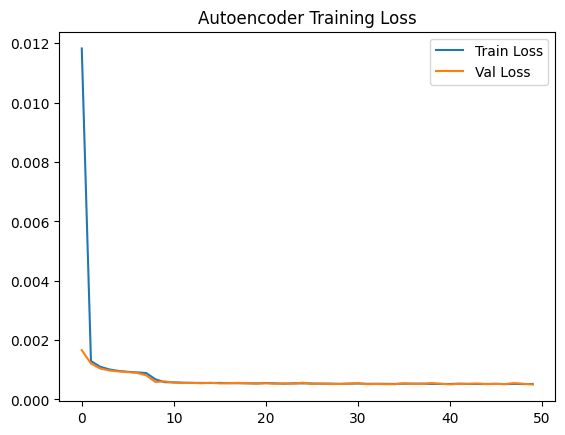

In [10]:
# Plot training loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Autoencoder Training Loss')
plt.show()

In [11]:
# Reconstruction error
X_pred = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - X_pred, 2), axis=1)

4298/4298 ━━━━━━━━━━━━━━━━━━━━ 4s 974us/step


In [12]:
# Add reconstruction error and anomaly label
df['recon_error'] = mse

In [13]:
# Set threshold: e.g., 95th percentile
threshold = np.percentile(mse, 95)
df['is_anomaly_ae'] = (df['recon_error'] > threshold).astype(int)
print(threshold)

0.002012576076366444


In [14]:
# Summary
print("Autoencoder Anomalies Detected:", df['is_anomaly_ae'].sum())

Autoencoder Anomalies Detected: 6872


In [15]:
# Save
df.to_csv('../data/processed/with_autoencoder.csv', index=False)

## Refining the model

In [22]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
import numpy as np

# True labels and anomaly scores
true_labels = merged_df['is_anomaly_ae_x']  # ✅ Ground truth
recon_errors = merged_df['recon_error']     # ✅ Autoencoder reconstruction error

# Compute precision, recall and thresholds
prec, rec, thresholds = precision_recall_curve(true_labels, recon_errors)

# Compute F1 scores
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-6)

# Find the best threshold
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]
print("🔍 Best threshold:", best_threshold)
print(f"F1 = {f1_scores[best_idx]:.4f}, Precision = {prec[best_idx]:.4f}, Recall = {rec[best_idx]:.4f}")

# Apply the threshold to get new predictions
merged_df['ae_pred_optimized'] = (merged_df['recon_error'] > best_threshold).astype(int)

print("📊 Classification Report after Threshold Tuning (Autoencoder):")
print(classification_report(true_labels, merged_df['ae_pred_optimized']))

🔍 Best threshold: 0.0019860595209361
F1 = 0.9250, Precision = 0.8605, Recall = 1.0000
📊 Classification Report after Threshold Tuning (Autoencoder):
              precision    recall  f1-score   support

           0       0.90      0.60      0.72        15
           1       0.86      0.97      0.91        37

    accuracy                           0.87        52
   macro avg       0.88      0.79      0.82        52
weighted avg       0.87      0.87      0.86        52



In [23]:
merged_df.to_csv('../data/processed/with_autoencoder_tuned.csv', index=False)